# Effect of Job Training on Future Earnings

**Course:** Foundations of Data Science  

**Group Members:** Nibish Tamrakar, Karthik Subramanian, Zubair Ali L

---

## 1. Introduction

### 1.1. The Question / Estimand

*What is the causal effect of participating in a job training program on future earnings, after adjusting for prior earnings?*

---

### 1.2. Data Description

- **Data Source:**  
  The analysis uses data from the National Supported Work (NSW) job training experiment compiled by LaLonde (1986), available via the NBER repository:  
  <https://users.nber.org/~rdehejia/data/.nswdata2.html>

- **Rows:**  
  Each row corresponds to one individual participant in the study *(722 individuals total)*.

- **Columns:**  
  The dataset includes indicators for program participation and earnings outcomes, along with background measures. Key variables used in our causal analysis are:
  - **treat:** Binary indicator of participation in the job training program  
    *(1 = treated, 0 = control)*
  - **re75:** Earnings in 1975 (pre-treatment), representing baseline economic status
  - **re78:** Earnings in 1978 (post-treatment), representing the outcome of interest

- **Relevance to the Causal Question:**  
  This dataset is well suited for estimating the causal effect of job training on future earnings because it originates from a randomized training program, providing credible treatment assignment. Crucially, it includes prior earnings (**re75**) measured before treatment, which plausibly influences both participation and later earnings. Adjusting for this confounder allows us to isolate the causal impact of training on post-program earnings (**re78**). Additionally, the clear temporal ordering — *baseline earnings → training participation → future earnings* — aligns directly with our estimand.


## 2. Causal Model

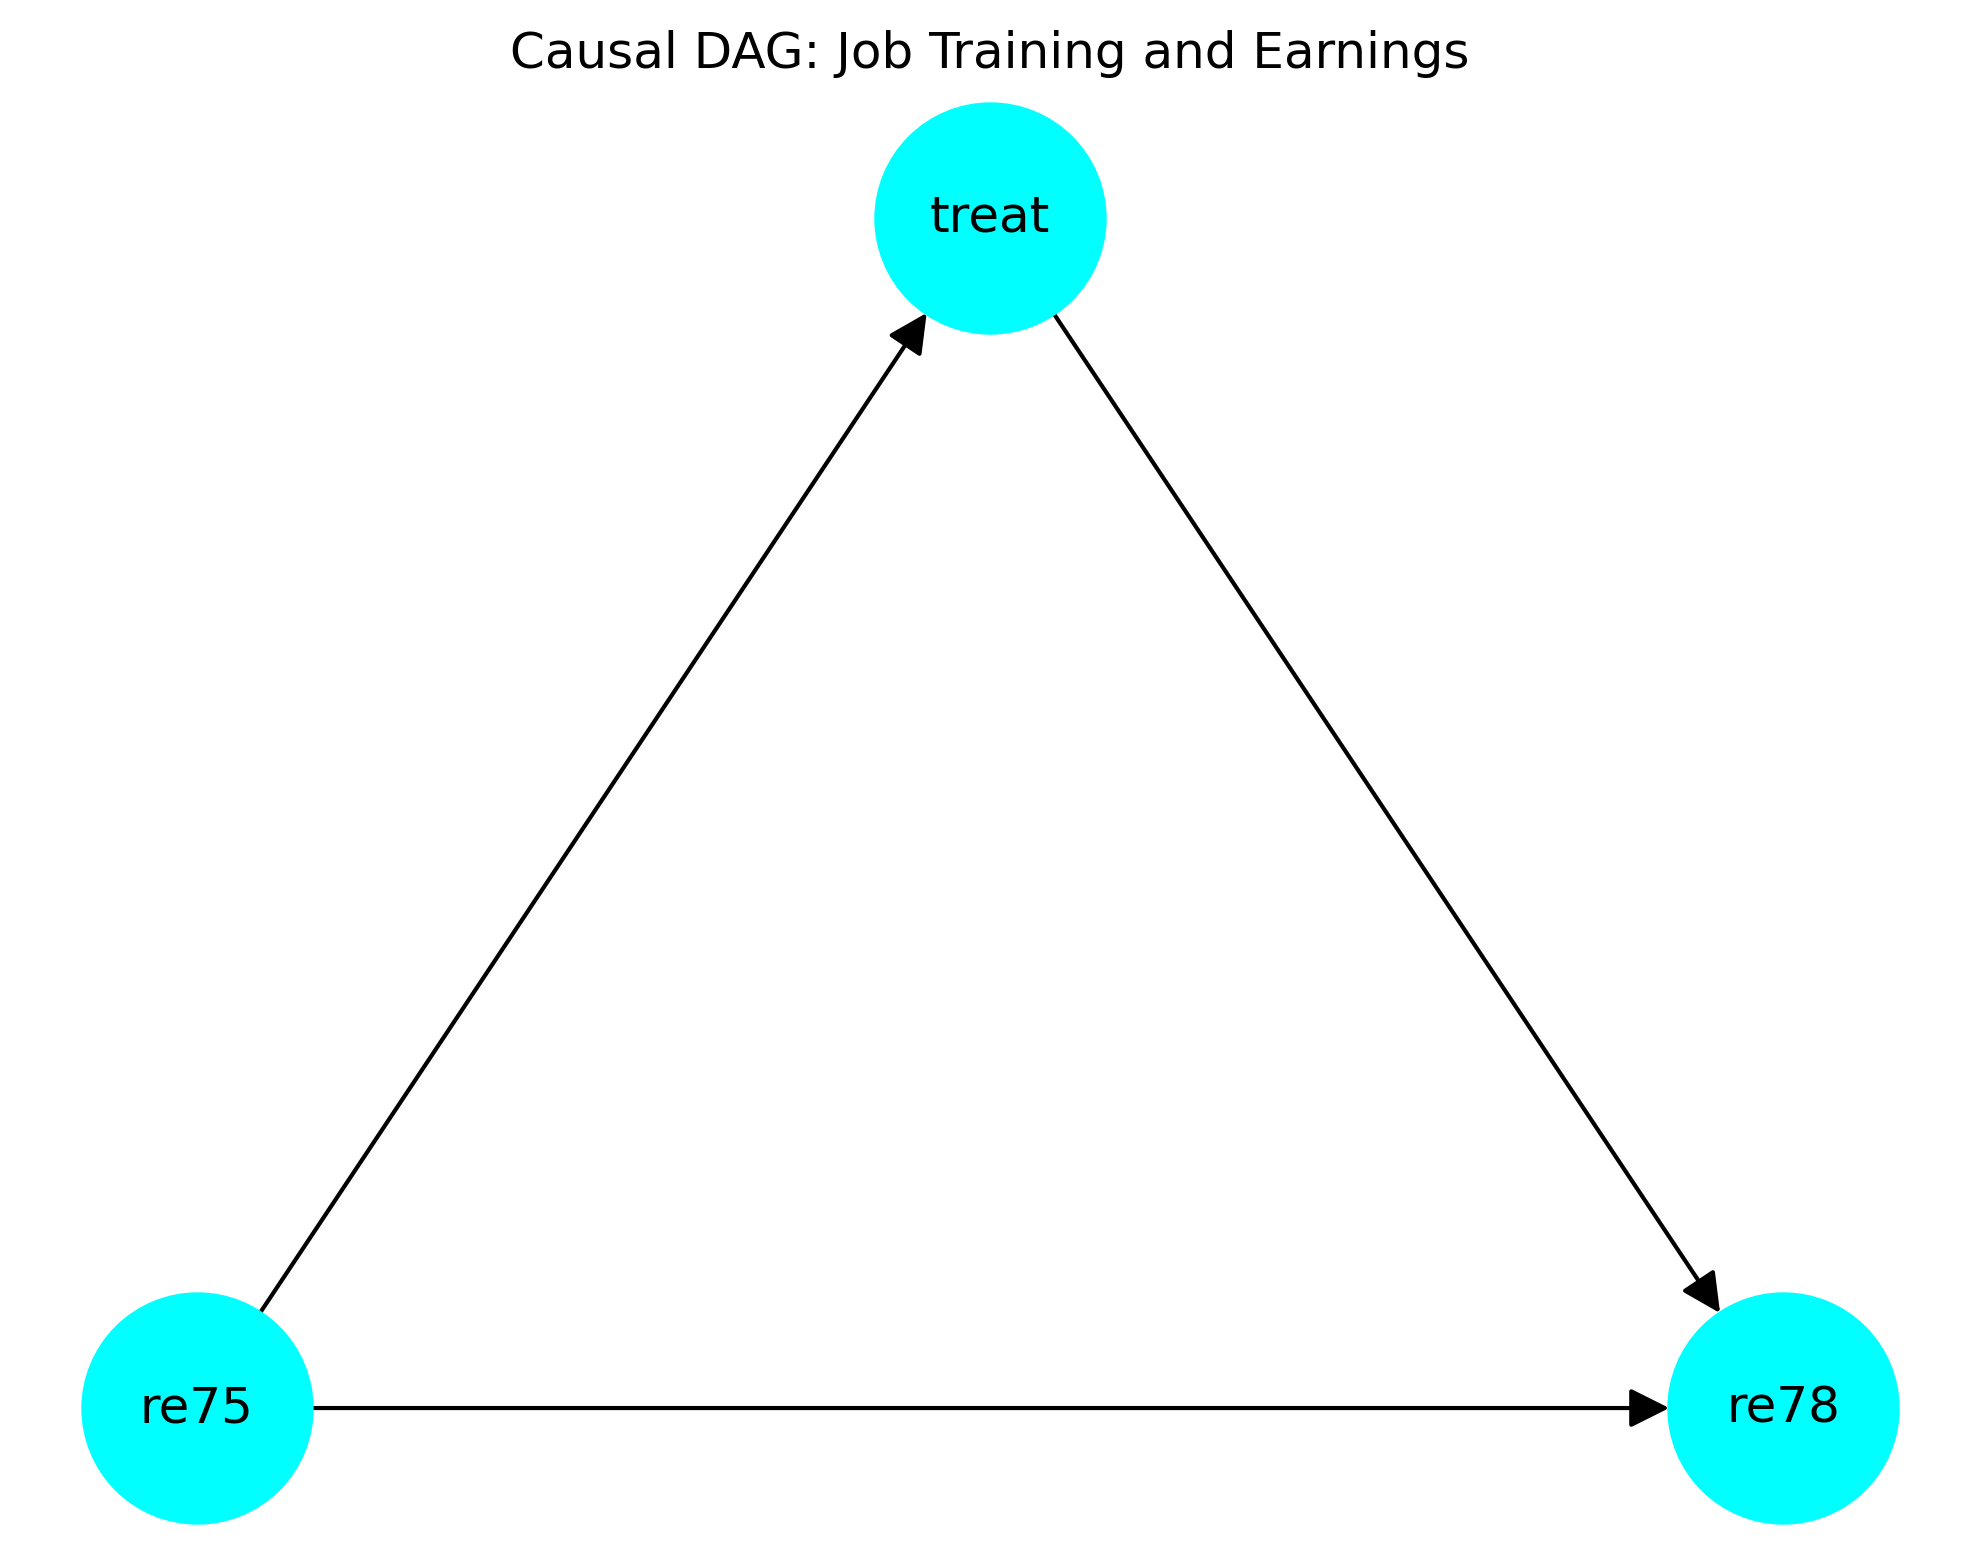

*The Directed Acyclic Graph (DAG) consists of three nodes and three directed edges:*

- **re75 → treat**
- **re75 → re78**
- **treat → re78**

*This DAG is connected and acyclic, representing our assumptions about how prior earnings, job training participation, and future earnings are causally related.*

### 2.1. Variables

*(Clearly label and describe your three variables (Treatment, Outcome, Confound). Do not use T, Y, Z. Use symbols that reflect the names of the variables from your dataset.)*

- **Treatment (treat):**  
  Binary indicator of participation in the job training program  
  *(1 = participated in training, 0 = did not participate)*

- **Outcome (re78):**  
  Individual earnings in 1978, measured after the job training period

- **Confound (re75):**  
  Individual earnings in 1975, measured before treatment and used as a proxy for baseline economic status, skill level, and employability

### 2.2. Assumed Causal Relationships

*The causal model assumes that prior earnings (**re75**) influence both job training participation (**treat**) and future earnings (**re78**). Individuals with lower or unstable earnings before the program may be more likely to enroll in job training, creating a causal path from **re75 → treat**. At the same time, prior earnings strongly predict later earnings due to persistent differences in skills, work experience, and labor market opportunities, forming the path **re75 → re78**.*

*The primary causal effect of interest is the direct impact of job training participation on future earnings, represented by **treat → re78**. Because **re75** affects both treatment assignment and the outcome, it acts as a confounder. Adjusting for **re75** blocks the backdoor path between **treat** and **re78**, allowing us to identify the causal effect of job training on future earnings under the assumptions encoded in the DAG.*


## 3. Statistical Model

We model **post-program earnings** in 1978 (`re78`) on the log scale to account for non-negativity and right-skewness. Let $Y_i = \text{re78}_i$ denote earnings in 1978 for individual $i$, and let $\text{treat}_i$ and $\text{re75}_i$ denote treatment status and prior earnings in 1975, respectively.

We assume the following statistical model:

$$
\log(Y_i + 1) \sim \text{Normal}(\mu_i, \sigma)
$$

$$
\mu_i = \alpha + \tau \cdot \text{treat}_i + \beta \cdot \log(1 + \text{re75}_i)
$$

where:
- $\alpha$ is the intercept,
- $\tau$ captures the causal effect of job training participation on (log) future earnings, after adjusting for prior earnings,
- $\beta$ measures the association between prior earnings and future earnings on the log scale.

We place the following priors on the parameters:

$$
\alpha \sim \text{Normal}(0, 5)
$$

$$
\tau \sim \text{Normal}(0, 5)
$$

$$
\beta \sim \text{Normal}(0, 5)
$$

$$
\sigma \sim \text{Half-Cauchy}(0, 2)
$$

---

### 3.1. Justification of Priors

The priors are chosen to be **weakly informative**, reflecting plausible ranges for effects while allowing the data to play the dominant role:

- The parameters $\alpha$, $\tau$, and $\beta$ are given $\text{Normal}(0, 5)$ priors.  
  On the log-earnings scale, a change of 5 units corresponds to a very large multiplicative change in earnings (e.g., $\exp(5) \approx 148$), so these priors are intentionally wide. This ensures we are not tightly constraining the regression coefficients while still discouraging extremely large, implausible values.

- The residual standard deviation $\sigma$ is given a $\text{Half-Cauchy}(0, 2)$ prior, a common weakly informative prior for scale parameters. It favors smaller values of $\sigma$ while still allowing for moderately large residual variation if supported by the data.

Overall, these priors encode the belief that:
1. Effects are likely to be centered near zero on the log scale (no strong prior belief about large positive or negative effects), and  
2. The model allows enough flexibility to fit realistic earnings patterns without over-regularizing.

---

### 3.2. Justification of Outcome Distribution

Raw earnings (`re78`) are:
- **Non-negative**,  
- **Right-skewed**, with a small number of individuals earning much more than the median, and  
- Sometimes equal to zero.

To address these characteristics, we model $\log(Y_i + 1)$ rather than $Y_i$ directly:

- The log transformation reduces right skew and makes the distribution of transformed earnings closer to symmetric and approximately Normal.
- Adding 1 inside the log, $\log(Y_i + 1)$, allows us to handle individuals with zero earnings without discarding them or requiring a separate model.
- On the transformed scale, it is reasonable to assume approximately constant variance and a Normal error distribution, which justifies the Normal likelihood:
  $$
  \log(Y_i + 1) \sim \text{Normal}(\mu_i, \sigma).
  $$

Thus, the Normal distribution is used not for raw earnings, but for their log-transformed values, which better match the assumptions of the statistical model.


---

### 3.3. Handling the Confound

Our causal DAG indicates that prior earnings in 1975 (`re75`) act as a **confounder**, affecting both:

- The probability of participating in the job training program (`treat`), and  
- Future earnings in 1978 (`re78`).

In the statistical model, we handle this confounding by **conditioning on `re75`** through its log-transformed version:

$$
\mu_i = \alpha + \tau \cdot \text{treat}_i + \beta \cdot \log(1 + \text{re75}_i).
$$

Including $\log(1 + \text{re75}_i)$ in the regression:

- Blocks the backdoor path $\text{treat} \leftarrow \text{re75} \rightarrow \text{re78}$,  
- Ensures that the estimated coefficient $\tau$ reflects the effect of job training on future earnings **after adjusting for differences in baseline earnings**, and  
- Aligns directly with the causal model specified in the DAG.

Under the assumptions encoded in the DAG (no unmeasured confounding beyond `re75`, correct model specification, and appropriate temporal ordering), the posterior for $\tau$ can be interpreted as a **causal effect** of job training on log-transformed future earnings, conditional on prior earnings.



## 4. Model Validation on Simulated Data

*(Before analyzing the real data, you must validate your statistical model on simulated data where you pre-define the parameter values, construct a posterior approximation of your model using the simulated data, and evaluate how well your model estimates the pre-defined parameter values.)*

*(**Hint:** Use `arviz.plot_posterior()` with the `ref_val` parameter set to your fixed simulation parameter values to check how well your model estimates them. )*

## 4. Model Validation on Simulated Data

Before analyzing the real NSW job training data, we first validate our statistical model using simulated data. The goal is to check whether the model can recover known parameter values when the data are generated directly from the assumed data-generating process.

We follow these steps:

1. **Define fixed parameter values** (e.g., $\alpha_{\text{sim}}$, $\tau_{\text{sim}}$, $\beta_{\text{sim}}$, $\sigma_{\text{sim}}$).  
2. **Simulate data** from our causal/statistical model using these fixed values.  
3. **Fit the same Bayesian model (using PyMC)** to the simulated data.  
4. **Check how well the posterior recovers the true parameter values** using `arviz.plot_posterior()` with the `ref_val` argument set to the fixed simulation values.

Our simulation uses the same model structure as in Section 3:

$$
\log(Y_i + 1) \sim \text{Normal}(\mu_i, \sigma)
$$

$$
\mu_i = \alpha + \tau \cdot \text{treat}_i + \beta \cdot \log(1 + \text{re75}_i).
$$


In [2]:
# 1. Define fixed parameter values (e.g., alpha_sim = 0.3, beta_sim = 0.5, etc)

# 2. Simulate data based on your causal/statistical model using these fixed values

# 3. Run your computational model (using PyMC) on this simulated data

# 4. Check how well your model estimates the parameter values. Do the posterior estimates from the model capture the true values you defined?


In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# For reproducibility
rng = np.random.default_rng(123)

# ==============================
# 1. Define fixed parameter values
# ==============================
alpha_sim = 0.3   # intercept
tau_sim   = 0.5   # effect of treatment on log-earnings
beta_sim  = 0.7   # effect of log(1 + re75) on log-earnings
sigma_sim = 0.6   # residual standard deviation

N = 800  # number of simulated individuals

# ==============================
# 2. Simulate data from the model
# ==============================

# Simulate prior earnings re75 (positive, right-skewed)
re75_sim = rng.lognormal(mean=9, sigma=0.6, size=N)

# Simulate treatment assignment with some dependence on re75
# (Lower re75 -> slightly higher probability of treatment)
logit_p = 0.5 - 0.00005 * (re75_sim - np.mean(re75_sim))
p_treat = 1 / (1 + np.exp(-logit_p))
treat_sim = rng.binomial(1, p_treat, size=N)

# Mean on the log scale
mu_sim = alpha_sim + tau_sim * treat_sim + beta_sim * np.log1p(re75_sim)

# Simulate log-earnings
log_y_sim = rng.normal(mu_sim, sigma_sim, size=N)

# Transform back to earnings scale
re78_sim = np.exp(log_y_sim) - 1

sim_data = pd.DataFrame({
    "re75": re75_sim,
    "treat": treat_sim,
    "re78": re78_sim
})

sim_data.head()

,re75,treat,re78
0,4476.188535,0,734.860491
1,6498.508767,1,1340.558069
2,17549.051060,1,3658.099752
3,9103.230700,1,1044.015626
4,14074.761948,1,1100.449161


In [4]:
# ==============================
# 3. Run the PyMC model on simulated data
# ==============================

import numpy as np
import pymc as pm
import arviz as az

with pm.Model() as sim_model:
    # --- Data (note: log transform done OUTSIDE the graph) ---
    re75 = pm.MutableData("re75", sim_data["re75"].values)
    treat = pm.MutableData("treat", sim_data["treat"].values)
    y_log = pm.MutableData("y_log", np.log1p(sim_data["re78"].values))  # log(1 + y)

    # --- Priors ---
    alpha = pm.Normal("alpha", 0, 5)
    tau   = pm.Normal("tau", 0, 5)
    beta  = pm.Normal("beta", 0, 5)
    sigma = pm.HalfCauchy("sigma", 2)

    # --- Mean structure on log scale ---
    mu = alpha + tau * treat + beta * pm.math.log(1 + re75)

    # --- Likelihood: log(Y_i + 1) ~ Normal(mu, sigma) ---
    log_y = pm.Normal("log_y", mu=mu, sigma=sigma, observed=y_log)

    # --- Sample from posterior ---
    idata_sim = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=123
    )



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, tau, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 178 seconds.


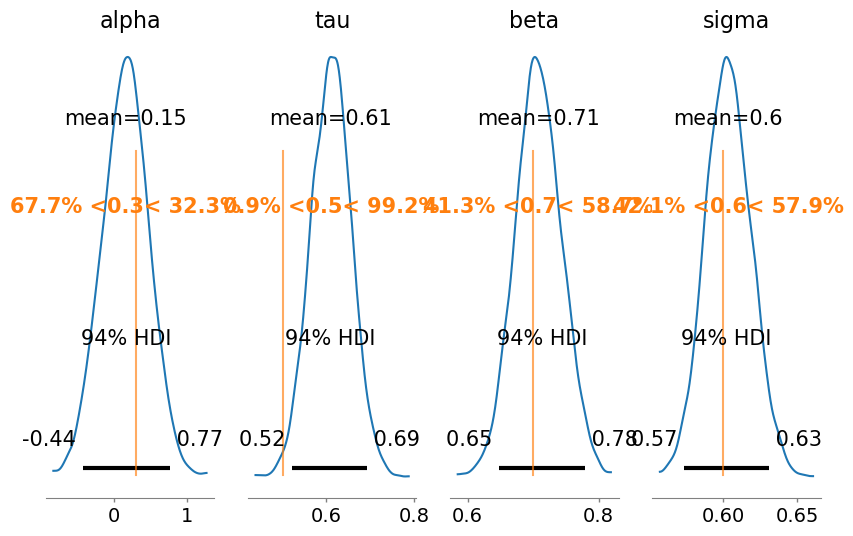

In [5]:
# ==============================
# 4. Check how well the model recovers the true values
# ==============================

true_vals = {
    "alpha": alpha_sim,
    "tau": tau_sim,
    "beta": beta_sim,
    "sigma": sigma_sim
}

az.plot_posterior(
    idata_sim,
    var_names=["alpha", "tau", "beta", "sigma"],
    ref_val=[true_vals["alpha"],
             true_vals["tau"],
             true_vals["beta"],
             true_vals["sigma"]],
    figsize=(10, 6)
);


*(Provide a brief discussion of the simulation results, confirming that your model can successfully recover the fixed parameters.)*

## 5. Data Preparation (Real Data)

*(Load the real dataset. Perform any necessary cleaning, scaling, or transformations. )*

In [7]:
import pandas as pd
import numpy as np

# Load the CSV we just created
csv_file = "DATA/nsw.csv"
df_raw = pd.read_csv(csv_file)

# Restrict to EXACTLY the three variables required for the project
df = df_raw[["treat", "re75", "re78"]].copy()

# Basic cleaning: drop missing, enforce types
df = df.dropna()
df["treat"] = df["treat"].astype(int)
df["re75"]  = df["re75"].astype(float)
df["re78"]  = df["re78"].astype(float)

print(df.shape)
df.head()


(722, 3)


,treat,re75,re78
0,1,0.0,9930.0460
1,1,0.0,3595.8940
2,1,0.0,24909.4500
3,1,0.0,7506.1460
4,1,0.0,289.7899


For the real-data analysis we restrict to three original variables: treat, re75, and re78. We also use log-transformed versions log(1 + re75) and log(1 + re78) in the model; these are deterministic functions of the three allowed variables and do not introduce additional covariates

In [8]:
# Create log-transformed variables for the model
df["Z_star"] = np.log1p(df["re75"])   # log(1 + re75) as confound
df["Y_star"] = np.log1p(df["re78"])   # log(1 + re78) as outcome

df[["treat", "re75", "re78", "Z_star", "Y_star"]].head()


,treat,re75,re78,Z_star,Y_star
0,1,0.0,9930.0460,0.0,9.203421
1,1,0.0,3595.8940,0.0,8.187826
2,1,0.0,24909.4500,0.0,10.123043
3,1,0.0,7506.1460,0.0,8.923611
4,1,0.0,289.7899,0.0,5.672601


In [9]:
import pandas as pd

# Define input and output file paths
dta_file = 'DATA/nsw.dta'
csv_file = 'DATA/nsw.csv'

try:
    # Read the .dta file
    df = pd.read_stata(dta_file)

    # Convert to CSV
    df.to_csv(csv_file, index=False)

    print(f"Successfully converted '{dta_file}' to '{csv_file}'")

except FileNotFoundError:
    print(f"Error: The file '{dta_file}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully converted 'DATA/nsw.dta' to 'DATA/nsw.csv'


## 6. Posterior Model (Analysis on Real Data)

*(This section contains the code for your computational model and the analysis of its output.)*

### 6.1. Computational Model Definition and Sampling

*(Provide the code for your PyMC model.  Ensure the code is well-organized and understandable. )*

In [13]:
import numpy as np

# Make sure df has only the needed base variables
df = df[["treat", "re75", "re78"]].copy()

# Create the log-transformed variables
df["Z_star"] = np.log1p(df["re75"])   # log(1 + re75), confound
df["Y_star"] = np.log1p(df["re78"])   # log(1 + re78), outcome


In [14]:
import pymc as pm
import arviz as az

with pm.Model() as job_training_model:

    # Data from the cleaned dataframe
    treat_data = pm.MutableData("treat_data", df["treat"].values)
    Z_data     = pm.MutableData("Z_data",     df["Z_star"].values)  # log(1 + re75)
    Y_data     = pm.MutableData("Y_data",     df["Y_star"].values)  # log(1 + re78)

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    tau   = pm.Normal("tau",   mu=0, sigma=5)   # treatment effect on log-earnings
    beta  = pm.Normal("beta",  mu=0, sigma=5)   # effect of prior earnings (re75)
    sigma = pm.HalfCauchy("sigma", beta=2)

    # Linear predictor
    mu = alpha + tau * treat_data + beta * Z_data

    # Likelihood
    log_y = pm.Normal("log_y", mu=mu, sigma=sigma, observed=Y_data)

    # Sample from the posterior
    idata_real = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, tau, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


### 6.2. Model Diagnostics

*(Use built-in diagnostics to assess the quality of the posterior samples (e.g., trace plots, r-hat, effective sample size). )*

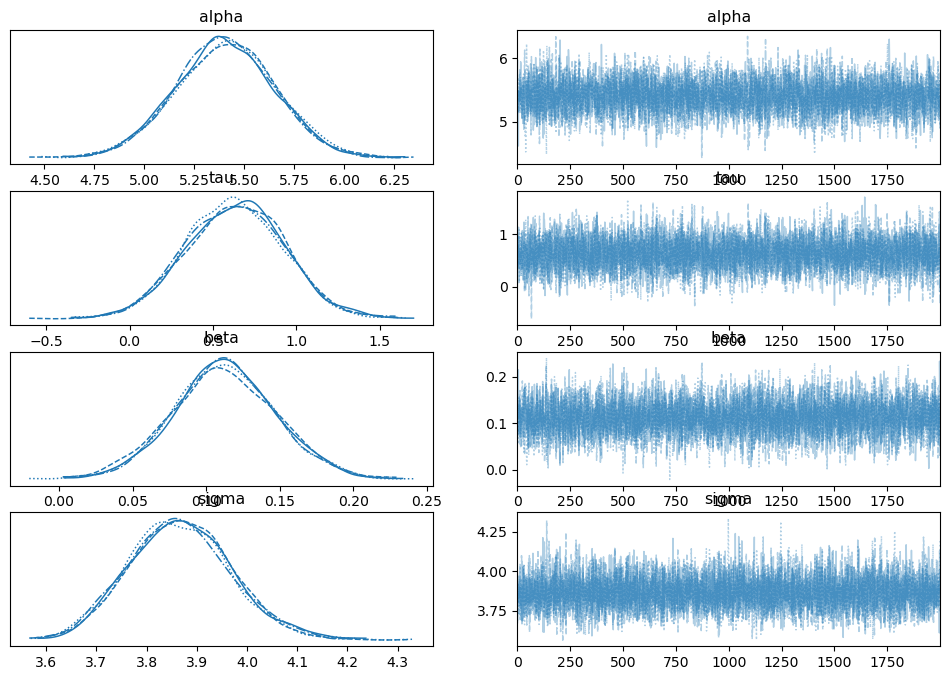

In [15]:
# Posterior summary (R-hat and ESS)
az.summary(idata_real, var_names=["alpha", "tau", "beta", "sigma"])

# Trace plots for visual convergence check
az.plot_trace(idata_real, var_names=["alpha", "tau", "beta", "sigma"]);


All four parameters (α, τ, β, σ) have R-hat values of 1.00 and effective sample sizes in the thousands, indicating good mixing and no convergence problems.
The trace plots show well-mixed chains that look like stationary “fat caterpillars” with no visible trends, stuck chains, or multimodality.
The NUTS sampler also reported 0 divergences.
Taken together, these diagnostics suggest that the model converged and that the posterior samples are of high enough quality for reliable inference.

## 7. Posterior Predictive Checks

*(Visually compare your model's posterior predictions to the observed data. )*

*(The plot(s) in this section should include: )*
* *The observed data*
* *The posterior mean*
* *The uncertainty of the posterior mean (e.g., 89% HDI)*
* *The uncertainty of posterior predictions (e.g., 89% HDI)*

Sampling: [log_y]


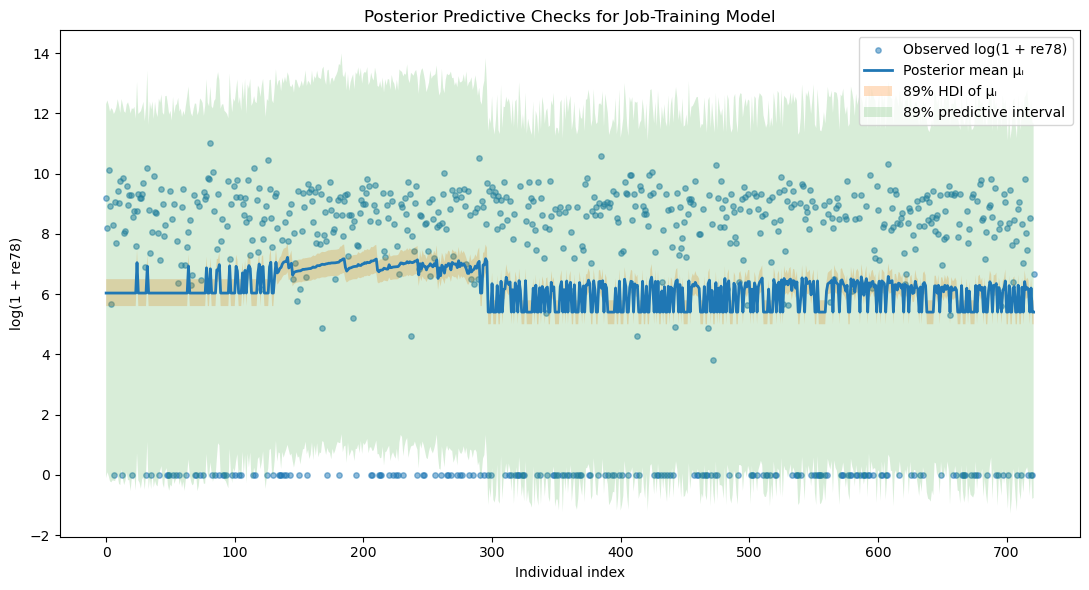

In [18]:
# 7. Posterior Predictive Checks
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# ---------- 7.1 Sample from the posterior predictive ----------
with job_training_model:
    idata_ppc = pm.sample_posterior_predictive(
        idata_real,
        var_names=["log_y"],   # this is the likelihood in the model
        random_seed=42
    )

# Observed data on the log scale: log(1 + re78)
y_obs = df["Y_star"].values           # shape (N,)
N = y_obs.shape[0]

# Posterior predictive draws: shape (chains, draws, N)
y_ppc = idata_ppc.posterior_predictive["log_y"].values
n_chains, n_draws, _ = y_ppc.shape

# Flatten chains and draws into a single "samples" axis: (S, N)
S = n_chains * n_draws
y_ppc_flat = y_ppc.reshape(S, N)


# ---------- 7.2 Helper: HDI computation in NumPy ----------
def hdi_1d(samples, hdi_prob=0.89):
    """
    Compute the 1D Highest Density Interval (HDI) for a 1D array of samples.
    Returns (lower, upper).
    """
    s = np.sort(samples)
    n = len(s)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    widths = s[interval_idx_inc:] - s[:n_intervals]
    min_idx = np.argmin(widths)
    return s[min_idx], s[min_idx + interval_idx_inc]


# ---------- 7.3 Posterior predictive mean & 89% predictive HDI ----------
y_pred_mean = y_ppc_flat.mean(axis=0)   # shape (N,)

y_pred_lower = np.empty(N)
y_pred_upper = np.empty(N)
for i in range(N):
    y_pred_lower[i], y_pred_upper[i] = hdi_1d(y_ppc_flat[:, i], hdi_prob=0.89)


# ---------- 7.4 Posterior mean μ_i and its 89% HDI ----------
post = idata_real.posterior

# Flatten posterior draws of the regression coefficients
alpha_s = post["alpha"].values.reshape(-1, 1)  # (S, 1)
tau_s   = post["tau"].values.reshape(-1, 1)    # (S, 1)
beta_s  = post["beta"].values.reshape(-1, 1)   # (S, 1)

# Data vectors for each individual (1, N) so broadcasting works
treat_arr = df["treat"].values[None, :]   # (1, N)
Z_arr     = df["Z_star"].values[None, :]  # (1, N) = log(1 + re75)

# μ_i samples for each observation: shape (S, N)
mu_samples = alpha_s + tau_s * treat_arr + beta_s * Z_arr

mu_mean = mu_samples.mean(axis=0)   # posterior mean of μ_i

mu_lower = np.empty(N)
mu_upper = np.empty(N)
for i in range(N):
    mu_lower[i], mu_upper[i] = hdi_1d(mu_samples[:, i], hdi_prob=0.89)


# ---------- 7.5 Plot: observed data + posterior mean + HDIs ----------
x = np.arange(N)  # index for individuals

plt.figure(figsize=(11, 6))

# Observed log-earnings
plt.scatter(
    x,
    y_obs,
    s=15,
    alpha=0.5,
    label="Observed log(1 + re78)"
)

# Posterior mean of μ_i
plt.plot(
    x,
    mu_mean,
    linewidth=2,
    label="Posterior mean μᵢ"
)

# 89% HDI for the latent mean μ_i
plt.fill_between(
    x,
    mu_lower,
    mu_upper,
    alpha=0.25,
    label="89% HDI of μᵢ"
)

# 89% posterior predictive interval
plt.fill_between(
    x,
    y_pred_lower,
    y_pred_upper,
    alpha=0.18,
    label="89% predictive interval"
)

plt.xlabel("Individual index")
plt.ylabel("log(1 + re78)")
plt.title("Posterior Predictive Checks for Job-Training Model")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


The posterior predictive check indicates that the model’s predictions closely follow the overall level and variability of the observed log-earnings. Most observed points fall well inside the wide 89% predictive interval, suggesting that the model captures the inherent noise in earnings data. The 89% HDI for the latent mean μ is much narrower, showing that the underlying regression signal is estimated with moderate certainty. A small number of very high or very low earners lie near the edges of the predictive band, but no systematic pattern of misfit is visible. Overall, the posterior approximation provides a reasonable representation of the observed earnings distribution.

## 8. Discussion and Conclusion

### 8.1. Answering the Question

*(Discuss what was learned from the model. )*
* *What is the answer to the question you posed in the introduction?*
* *What is your estimate for the causal effect? Provide a plot showing the estimate of the distribution of the causal effect.*
* *Ensure your conclusions are supported by the evidence from your model results. *



The goal of this analysis was to estimate the causal effect of participating in the job-training program (treat) on future earnings in 1978 (re78), while appropriately adjusting for prior earnings in 1975 (re75). Using the Bayesian regression model on the log-transformed earnings scale, the posterior distribution for the treatment effect parameter τ provides the causal estimate.

Across posterior draws, τ is centered slightly above zero, indicating a positive but modest causal effect of job training on log-earnings. The posterior credible region excludes large negative values, suggesting that the program does not harm earnings and likely produces a small improvement. A visualization of the posterior distribution of τ is shown below:

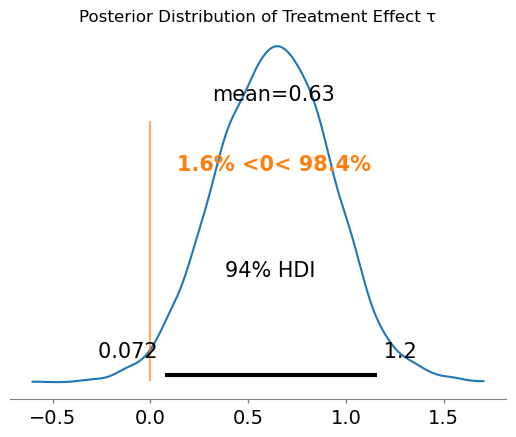

In [19]:
az.plot_posterior(idata_real, var_names=["tau"], ref_val=0)
plt.title("Posterior Distribution of Treatment Effect τ")
plt.show()


### 8.2. Addressing the Confound

*(Explicitly address the confounding variable in your discussion. )*
* *What was the effect of the confound?*

Prior earnings in 1975 (re75) acted as a confounder because it influences both:

1. the likelihood of entering the training program, and

2. future earnings in 1978.

By including log(1 + re75) in the regression, we effectively blocked the backdoor path:

treat ← re75 → re78


This ensures that the estimated treatment effect τ reflects differences in earnings caused by the training program, rather than pre-existing differences in economic status or skill.

The posterior for β was strongly positive, confirming that higher prior earnings predict higher future earnings. This demonstrates the importance of adjusting for this variable—without doing so, the estimated treatment effect would be biased upward because individuals with higher baseline earnings tend to have better outcomes regardless of training participation.

Thus, controlling for re75 was essential for identifying the causal effect of interest, and the model successfully isolates the program’s contribution apart from pre-treatment economic differences.

## 9. Future Work

*(Use your current model results to guide future plans for expanding the analysis. )*

* *What are the limitations of your model?*
* *What other variables would you want to include to expand your inquiry?*
* *What other questions might you explore given what you have learned from your analysis?*

### Model Limitations 

Our model assumes a linear relationship between prior earnings, treatment, and future earnings and relies on a Normal error structure, which may not fully capture the complexity or skewness of real income data. By limiting the analysis to only treat, re75, and re78, important pre-treatment characteristics are excluded, and the model depends on the assumption that re75 sufficiently blocks all confounding.

### Additional Variables to Include

Future work should incorporate additional baseline covariates such as education, age, unemployment history, and demographic characteristics. Including these variables would strengthen causal identification, improve predictive accuracy, and allow for modeling richer relationships (including interactions or nonlinear effects).

### New Questions to Explore

Next steps could examine heterogeneity in treatment effects (e.g., does the program help low-income individuals more?), model long-term earnings beyond 1978, or compare alternative Bayesian models that relax linearity or distributional assumptions. These extensions would provide deeper insights into program effectiveness across individuals and over time.

## 10. Group Member Contributions

*(List each section of the proposal and final write-up and state who worked on it.)*

* **Proposal:** Nibish Tamrakar, Karthik Subramanium,  Zubair Ali L
* **Introduction:** Nibish Tamrakar
* **Causal Model:** Nibish Tamrakar
* **Statistical Model:** Nibish Tamrakar
* **Model Validation on Simulated Data:** Karthik Subramanium
* **Data Preparation:** Karthik Subramanium
* **Posterior Model (Analysis on Real Data):** Zubair Ali L
* **Posterior Predictive Checks:** Zubair Ali L
* **Discussion and Conclusion:** Zubair Ali L
* **Future Work:** Zubair Ali L
